In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils
from notebook_shared import violinplotutil

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
sns.set(font_scale=1.2)

In [3]:
df[['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id']]

,driver_invocation,workload_invocation,provider,region,1_run_id
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,28
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,69
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,74
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,86
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,103
...,...,...,...,...,...
499531,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,19
499532,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,35
499533,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,83
499534,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,90


In [4]:
df.columns

Index(['driver_invocation', 'workload_invocation', 'provider', 'region',
       'dirty_measurement', 'folder_uuid', '1_run_id', '2_thread_id',
       'SAAFMemoryDeltaError', 'SAAFMemoryError', 'contextSwitches',
       'contextSwitchesDelta', 'cpuIdle', 'cpuIdleDelta', 'cpuIowait',
       'cpuIowaitDelta', 'cpuIrqDelta', 'cpuKrn', 'cpuKrnDelta', 'cpuModel',
       'cpuNice', 'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr',
       'cpuUsrDelta', 'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas',
       'freeMemory', 'functionName', 'latency', 'linuxVersion', 'newcontainer',
       'roundTripTime', 'runtime', 'runtimeOverlap', 'startTime',
       'totalMemory', 'userRuntime', 'uuid', 'vmcpusteal', 'vmcpustealDelta',
       'vmuptime', 'containerID', 'functionMemory', 'pageFaults',
       'pageFaultsDelta', 'vmID', 'dow_utc', 'tod_utc', 'timezone',
       'measure group', 'local_dow', 'local_tod'],
      dtype='object')

In [5]:
df = df.sort_values(by=['provider', 'measure group', 'region', 'driver_invocation', 'workload_invocation'])

In [6]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        # exception handling:
        plot_region = region
        if region == 'northamerica-northeast1':
            plot_region = 'northamerica\n-northeast1'
        if region == 'southamerica-east1':
            plot_region = 'southamerica-\neast1'
        if region == 'australia-southeast1':
            plot_region = 'australia\n-southeast1'
        
        provider_region_mapping[f"({provider}, {region})"] = {
            'region': region,
            'plot region': plot_region,
            'measure group': measure_group,
            'provider': provider
        }
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {
            'region': region,
            'plot region': plot_region,
            'measure group': measure_group,
            'provider': provider
        }

# Mean Runtime and CV Per Provider
- Q: Has a provider a overall characterstics or do specific regions stand out?
- Q: Does have one provider an overall more volatile region?

In [7]:
cov_df = df.groupby( ['provider', 'region'], observed=True)['runtime'].apply(utils.cov)

AWS


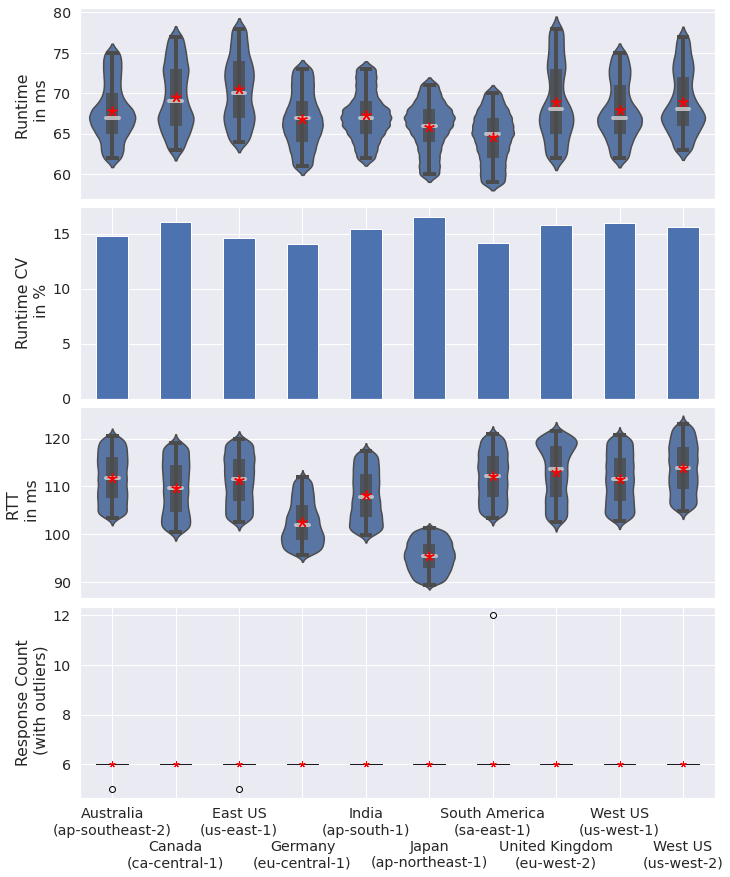

runtimebx 
                         runtime                                               \
                          count       mean       std   min   25%   50%   75%   
provider region                                                                
AWS      ap-southeast-2  9408.0  70.475553  4.010277  64.0  67.0  70.0  74.0   
         ca-central-1    8745.0  66.825386  3.381512  61.0  64.0  67.0  69.0   
         us-east-1       9390.0  68.945154  4.672155  62.0  65.0  68.0  73.0   
         eu-central-1    9057.0  67.253285  2.960782  62.0  65.0  67.0  69.0   
         ap-south-1      9049.0  69.572881  4.030336  63.0  66.0  69.0  73.0   
         ap-northeast-1  9345.0  67.828036  3.549471  62.0  65.0  67.0  70.0   
         sa-east-1       9188.0  64.531672  3.121148  59.0  62.0  65.0  67.0   
         eu-west-2       9208.0  65.848719  2.994297  60.0  64.0  66.0  68.0   
         us-west-1       9030.0  67.897896  3.594335  62.0  65.0  67.0  71.0   
         us-west-2       941

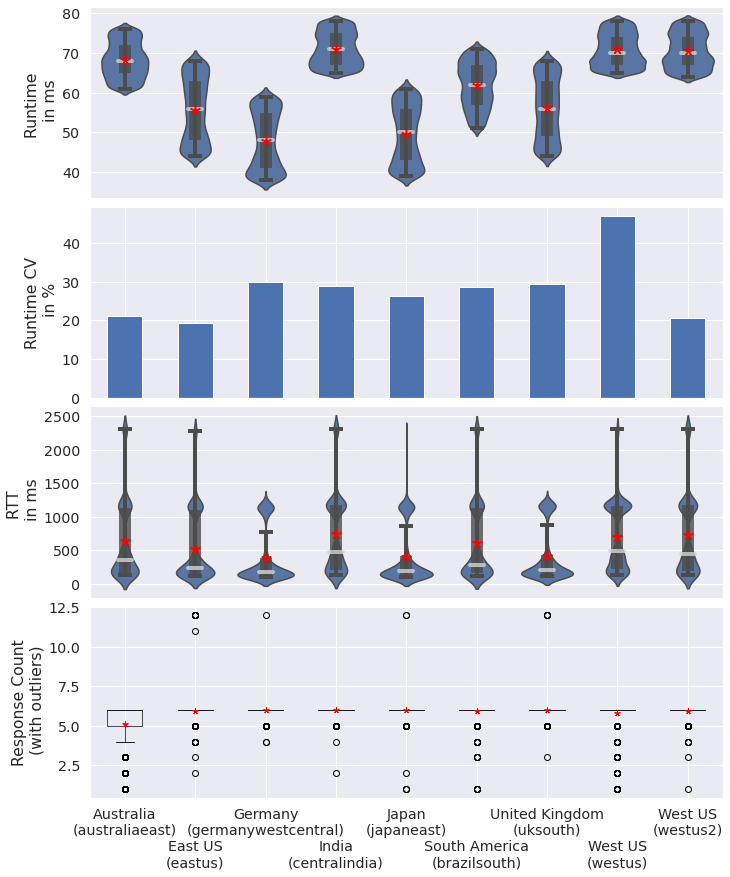

runtimebx 
                             runtime                                         \
                              count       mean       std   min   25%   50%   
provider region                                                              
AZURE    australiaeast       7506.0  68.190514  4.410024  61.0  65.0  68.0   
         eastus              9143.0  71.009297  4.029211  65.0  67.0  71.0   
         germanywestcentral  9075.0  49.501708  7.134564  39.0  43.0  50.0   
         centralindia        8833.0  47.949734  7.062910  38.0  41.0  48.0   
         japaneast           9011.0  61.955166  5.608796  51.0  57.0  62.0   
         brazilsouth         8870.0  55.755017  7.831584  44.0  48.0  56.0   
         uksouth             9014.0  56.034835  7.519928  44.0  49.0  56.0   
         westus              8537.0  70.820780  3.990320  65.0  67.0  70.0   
         westus2             9151.0  70.528248  4.229204  64.0  67.0  70.0   

                                         
         

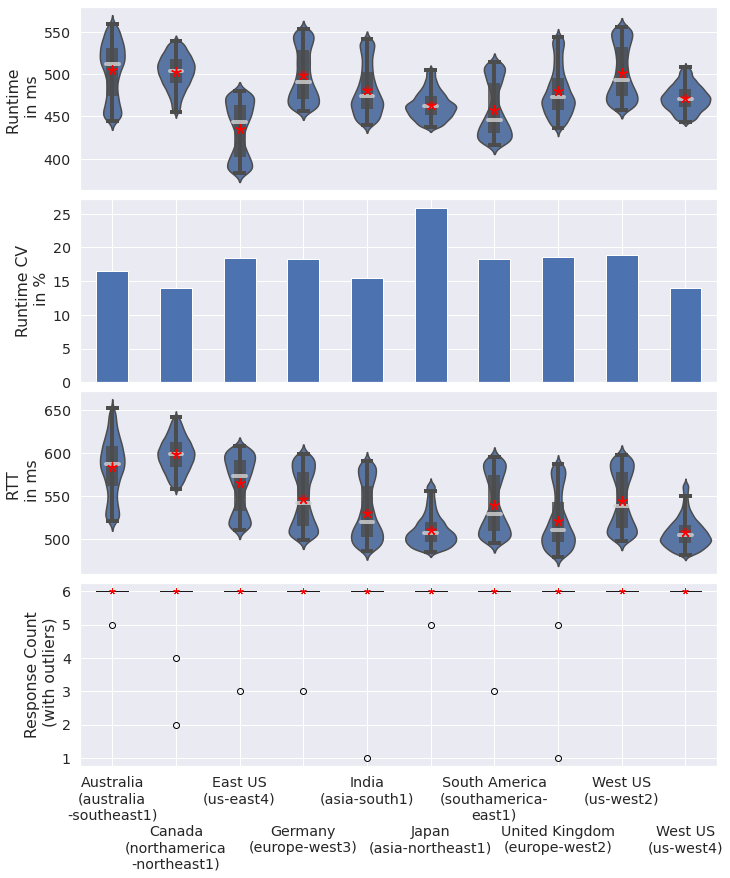

runtimebx 
                                  runtime                                       \
                                   count        mean        std    min    25%   
provider region                                                                 
GCP      australia-southeast1     8827.0  434.982554  32.111576  383.0  402.0   
         northamerica-northeast1  8775.0  463.632707  15.965983  437.0  452.0   
         us-east4                 8753.0  479.848395  28.409398  436.0  458.0   
         europe-west3             8796.0  481.524329  28.796839  440.0  459.0   
         asia-south1              8721.0  502.768375  19.807063  455.0  489.0   
         asia-northeast1          8772.0  504.495554  33.065054  445.0  474.0   
         southamerica-east1       8804.0  457.245457  31.880828  416.0  430.0   
         europe-west2             8806.0  498.544402  30.498896  456.0  471.0   
         us-west2                 8779.0  501.491742  31.320774  458.0  474.0   
         us-west

In [8]:
sns.set(font_scale=1.3)

for provider in df['provider'].unique():
    SHAREX = True
    fig, axes = plt.subplots(figsize=(10,12), nrows=4, frameon=False, sharex=SHAREX)
    
    # Runtime
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    
    
    pdf['runtime'] = pdf['runtime'].astype(np.float64)
    pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
    violinplotutil.violinplot(x='region', y='runtime', ax=axes[0], data=pdf)
    
    axes[0].set_ylabel('Runtime \n in ms')
    
    bxdf = pdf.groupby(['provider','region'], observed=True)
    
    # COV
    cov_provider = cov_df.loc[provider] 
    cov_provider = cov_provider * 100
    cov_provider.plot(kind='bar', ax=axes[1], sharex=SHAREX)
    axes[1].set_ylabel('Runtime CV\n in %')
    
    # Round Trip Time
    if (provider == "AWS"):
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        
        
        
        # pdf = utils.remove_outliers_group(pdf, 'region', 'roundTripTime')
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        
        # todo check if ok
        pdf['roundTripTime'] = pdf['roundTripTime'].astype(np.float64)
        pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
        violinplotutil.violinplot(x='region', y='roundTripTime', ax=axes[2], data=pdf)
        
        rtt_df = pdf.groupby(['region'], observed=True)
        # utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, rot=90, sharex=SHAREX, showfliers=True)
    else:
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        
        # todo check if ok
        pdf['roundTripTime'] = pdf['roundTripTime'].astype(np.float64)
        pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
        violinplotutil.violinplot(x='region', y='roundTripTime', ax=axes[2], data=pdf)
        
        rtt_df = pdf.groupby(['region'], observed=True)
    
    axes[2].set_ylabel('RTT \n in ms')
    
    # resp df
    resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
    df_resp_boxplot = resp_df[['provider', 'region', 'counts']].groupby(['provider', 'region'], observed=True)
    ax = utils.boxplot(axes[3], df_resp_boxplot, 'Response Count\n (with outliers)', lambda x: x, rot=0, sharex=False, showfliers=True, with_mean=True)
    
    # Set Region Names
    region_name_ax = ax
    labels = []
    i = 0
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        plot_region = mapping['plot region']
        measure_group = mapping['measure group']
        if (i % 2) == 1:
            if provider == 'GCP':
                labels.append(f"\n\n\n{measure_group}\n({plot_region})")
            else:
                labels.append(f"\n\n{measure_group}\n({plot_region})")
        else:
            labels.append(f"{measure_group}\n({plot_region})")
        i+=1

    region_name_ax.set_xticklabels(labels)
    region_name_ax.set_xlabel('')

    fig.tight_layout(pad=0)

    print(provider)
    utils.plot( ['region_analysis', f'overview_{provider}'], runtimebx=bxdf.describe(), rttbx=rtt_df.describe(), respbx=df_resp_boxplot.describe(), cov=cov_provider)

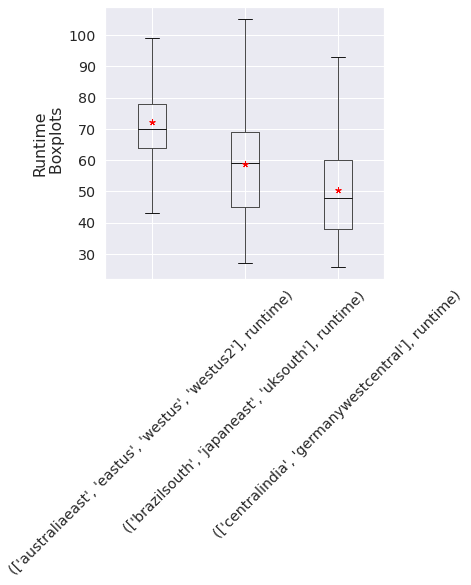

In [9]:
# Get MF finding numners for Azure Groups:
# % TODO: Calculate average runtimes for the different groups:
group_1 = ['australiaeast', 'eastus', 'westus', 'westus2']
group_2 = ['brazilsouth', 'japaneast', 'uksouth']
group_3 = ['centralindia', 'germanywestcentral']

df_grouped_runtime = df[df['region'].isin(group_1 + group_2 + group_3)][['provider', 'region', 'runtime']]
df_grouped_runtime['group'] = 'none'
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_1), 'group'] = str(group_1)
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_2), 'group'] = str(group_2)
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_3), 'group'] = str(group_3)

df_grouped_runtime_result = df_grouped_runtime.groupby('group')

# CV Boxplots
fig, axes = plt.subplots(figsize=(5,5))
utils.boxplot(axes, df_grouped_runtime_result, "Runtime\n Boxplots", lambda x: x, with_mean=True,rot=45)
utils.savefig(fig, ['region_analysis', f'azure_grouped_runtime'], data=df_grouped_runtime_result.describe())

## Runtime Distribution Across All Providers

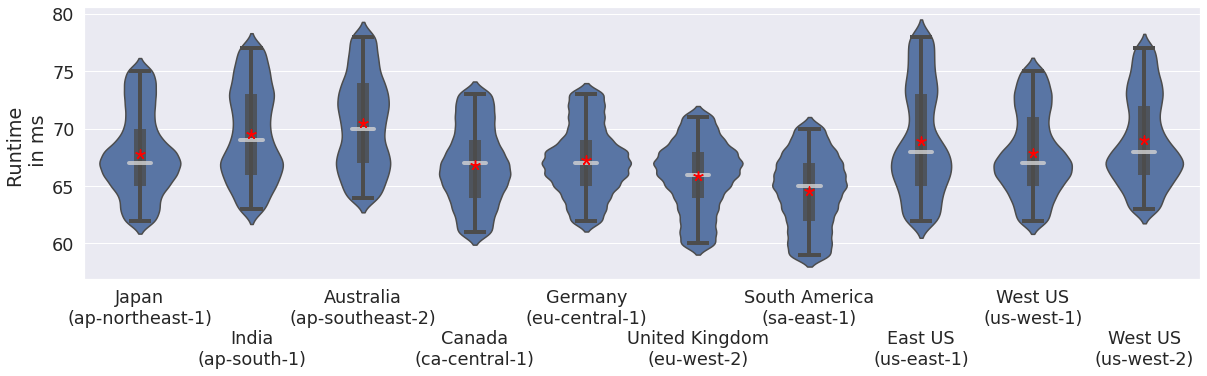

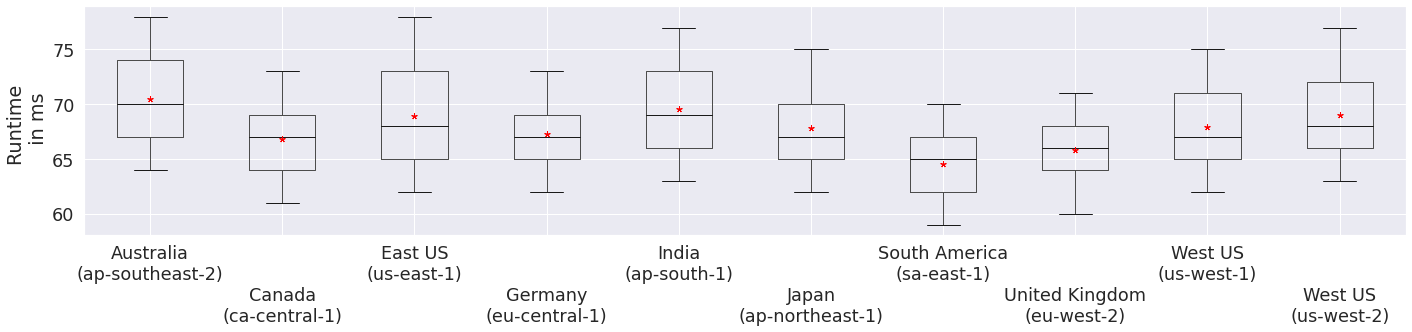

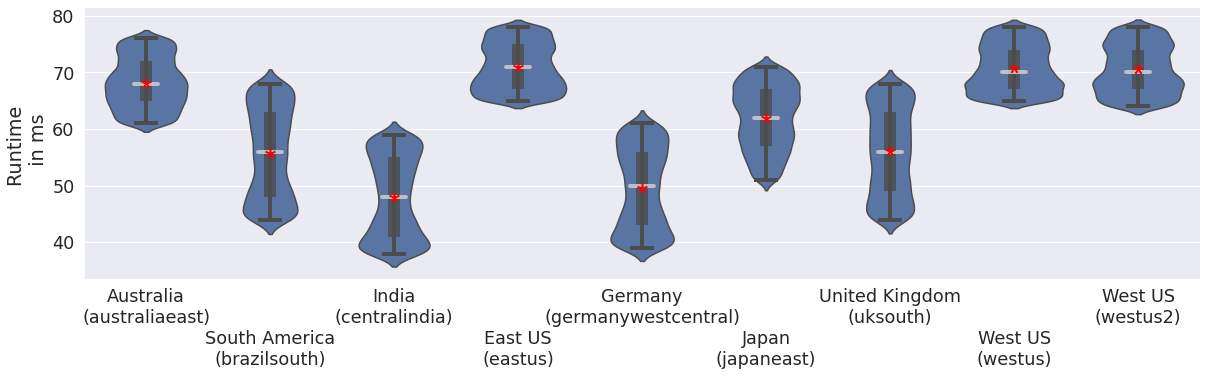

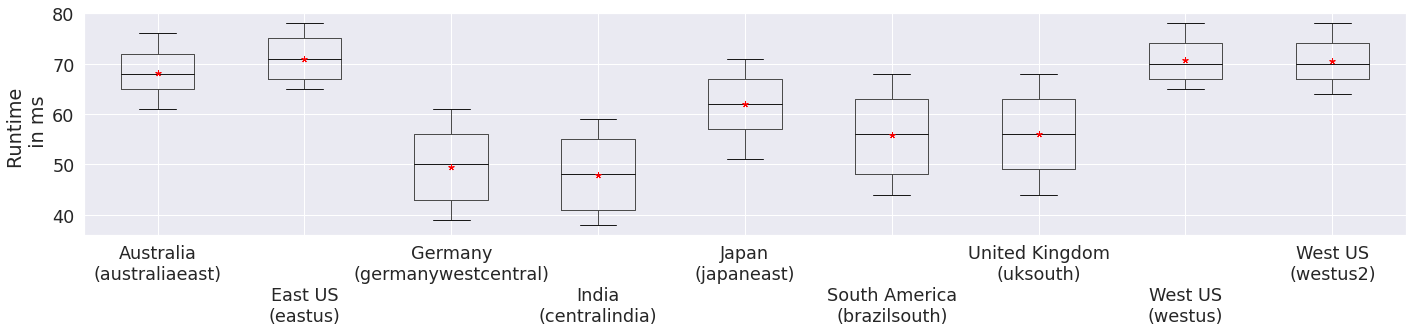

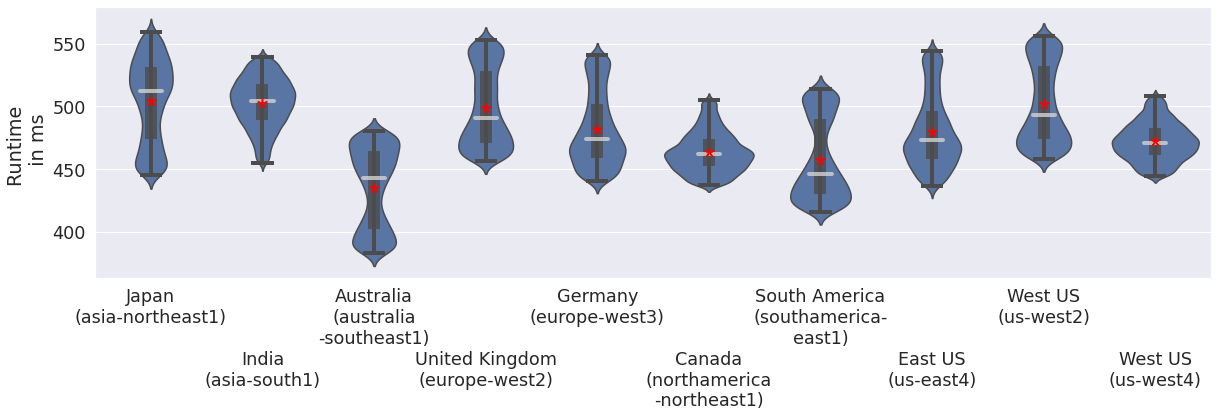

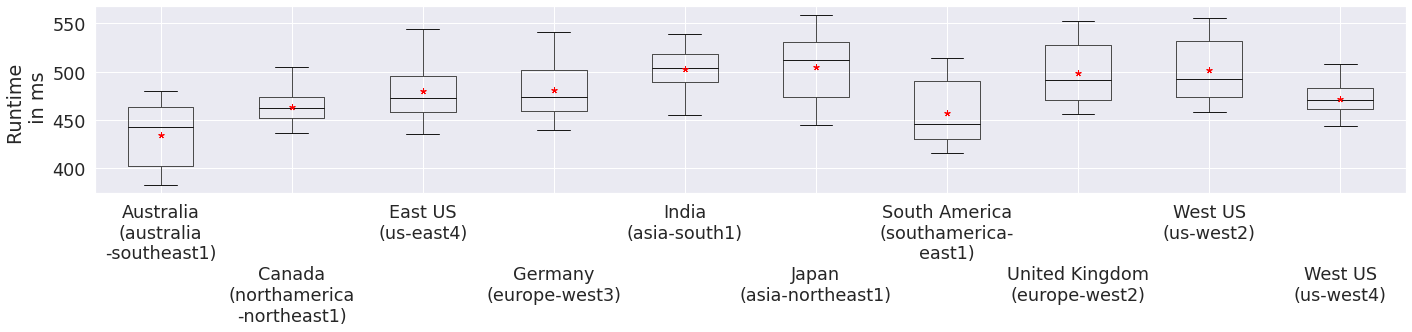

In [10]:
sns.set(font_scale=1.6)

for provider in df['provider'].unique():
    SHAREX = False
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    regions = list(pdf['region'].unique())
    no_regions = len(regions)
    fig, axes = plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    index = 0
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    
    # todo check if ok
    pdf['runtime'] = pdf['runtime'].astype(np.float64)
    pdf['region'] = pdf['region'].cat.remove_unused_categories()
    
    ax = violinplotutil.violinplot(x='region', y='runtime', ax=axes, data=pdf)
    
    axes.set_ylabel('Runtime \n in ms')
    
    utils.savefig(fig, ['region_analysis', f'runtime_violin_provider_{provider}'],
             bxdf=pdf.groupby('region').describe()
                 )
    
    region_name_ax = ax
    labels = []
    i=0
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        plot_region = mapping['plot region']
        measure_group = mapping['measure group']
        if (i % 2) == 1:
            if provider == 'GCP':
                labels.append(f"\n\n\n{measure_group}\n({plot_region})")
            else:
                labels.append(f"\n\n{measure_group}\n({plot_region})")
        else:
            labels.append(f"{measure_group}\n({plot_region})")
        i+=1
    region_name_ax.set_xticklabels(labels, rotation=0)
    region_name_ax.set_xlabel('')
        
    fig = plt.figure(figsize=(20,5))  #plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    ax = plt.gca()
    
    bxdf = pdf.groupby(['provider','region'], observed=True)
    ax = utils.boxplot(ax, bxdf, "Runtime \n in ms", lambda x: x, rot=0, sharex=False, with_mean=True)
    
    region_name_ax = ax
    labels = []
    i = 0
    for tick in region_name_ax.get_xticklabels():
        region =  tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        plot_region = mapping['plot region']
        measure_group = mapping['measure group']
        if (i % 2) == 1:
            if provider == 'GCP':
                labels.append(f"\n\n\n{measure_group}\n({plot_region})")
            else:
                labels.append(f"\n\n{measure_group}\n({plot_region})")
        else:
            labels.append(f"{measure_group}\n({plot_region})")
        i+=1

    region_name_ax.set_xticklabels(labels, rotation=0)
    region_name_ax.set_xlabel('')
    
    fig.tight_layout()
    
    utils.savefig(fig, ['region_analysis', f'runtime_boxplot_provider_{provider}'],
             bxdf=bxdf.describe()
                 )

In [11]:
cov_mg_df = df.groupby( ['measure group', 'provider', 'region'], observed=True)['runtime'].apply(utils.cov)
cov_mg_df_percent = cov_mg_df * 100
cov_mg_df_percent

measure group   provider  region                 
Australia       AWS       ap-southeast-2             14.827087
                AZURE     australiaeast              21.229942
                GCP       australia-southeast1       16.480741
Canada          AWS       ca-central-1               16.034844
                GCP       northamerica-northeast1    13.992046
East US         AWS       us-east-1                  14.636672
                AZURE     eastus                     19.429611
                GCP       us-east4                   18.451491
Germany         AWS       eu-central-1               14.084596
                AZURE     germanywestcentral         29.807909
                GCP       europe-west3               18.243833
India           AWS       ap-south-1                 15.434817
                AZURE     centralindia               28.836876
                GCP       asia-south1                15.490476
Japan           AWS       ap-northeast-1             16.557098
     

In [12]:
num_max_regions_group = df.groupby( ['measure group'], observed=True)['region'].nunique().max()
mgs = set(cov_mg_df_percent.index.get_level_values(0))
# mgs_values = {}

mgs_values = {}
for mg in mgs:
    mgs_values[mg] = []

for index, row in cov_mg_df_percent.reset_index().iterrows():
    mg = row['measure group']
    p = row['provider']
    r = row['region']
    runtime = row['runtime']
    mgs_values[mg] = mgs_values[mg] + [{'runtime': runtime, 'provider': p , 'region': r}]
# mgs_values

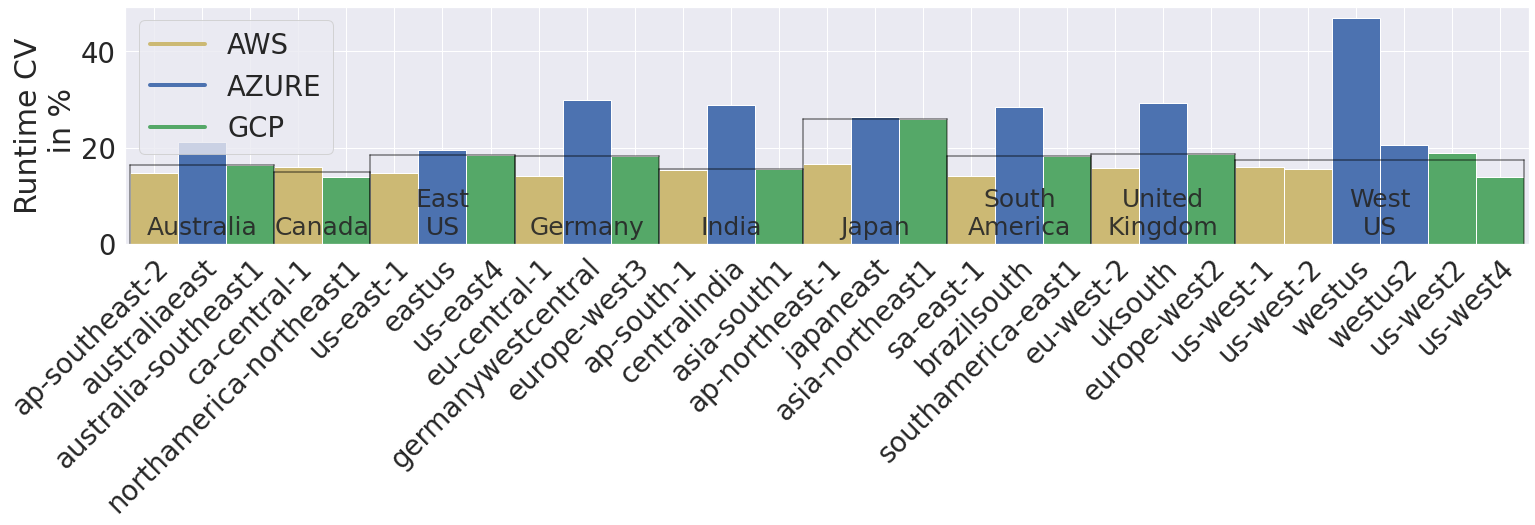

In [37]:
cov_mg_df = cov_mg_df_percent.reset_index().groupby( ['measure group'], observed=True)['runtime'].median()
cov_mg = cov_mg_df.to_dict()
cov_mg

fig, ax = plt.subplots(figsize=(22,8))
sns.set(font_scale=2.5)
w = 1
x = 0
ticks = []
labels = []
for group_idx, mg in enumerate(sorted(mgs)):   
    grp_start = x
    
    for value_idx, values in enumerate(mgs_values[mg]):
        x +=1
        p = values['provider']
        r = values['region']
        c = 'black'
        if values['provider'] == 'AWS':
            c = 'y'
        if values['provider'] == 'AZURE':
            c = 'b'    
        if values['provider'] == 'GCP':
            c = 'g'    
        ax.bar(x, values['runtime'], w, label=p, color = c)
        
        ticks.append(x)
        labels.append(r)
    grp_end = x
    
    xgs = grp_start + 0.5 * w
    xge = grp_end + 0.5 * w
    gy = cov_mg[mg]
    ax.plot([xgs, xge], [gy, gy], color = 'black', alpha=0.5)
    
    # Region
    xgm = (xgs) + (xge - xgs)/2
    
    ax.plot([xgs,  xgs], [gy, 0], color = 'black', alpha=0.5)
    ax.plot([xge,  xge], [gy, 0], color = 'black', alpha=0.5)
    ax.annotate(mg.replace(' ', '\n'), (xgm , 2), ha='center', fontsize=25, alpha=0.9)

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

fig.tight_layout(pad=0)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]
ax.legend(custom_lines, ['AWS', 'AZURE', 'GCP'])

ax.set_xlim(0.4, 29.6)

ax.set_ylabel('Runtime CV\n in %')
fig.tight_layout()
utils.savefig(fig, ['region_analysis', f'cv_all_regions'], data=cov_df)

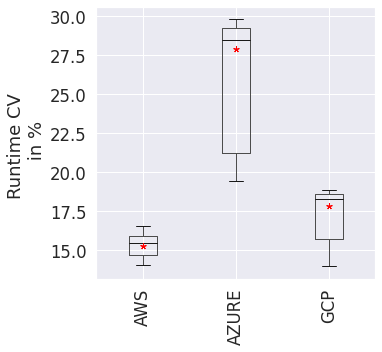

In [14]:
# CV Boxplots
cov_df.groupby('provider')
fig, axes = plt.subplots(figsize=(5,5))

cov_df_percent = cov_df * 100
bxdf = cov_df_percent.reset_index().groupby(['provider'])
axes = utils.boxplot(axes, bxdf, "Runtime CV \n in %", lambda x: x, rot=45, with_mean=True)

labels = []
for tick in axes.get_xticklabels():
    provider =  tick.get_text().split(',')[0].strip()[1:]
    labels.append(provider)
axes.set_xticklabels(labels, rotation=90)

utils.savefig(fig, ['region_analysis', f'cv_boxplot'], data=cov_df)

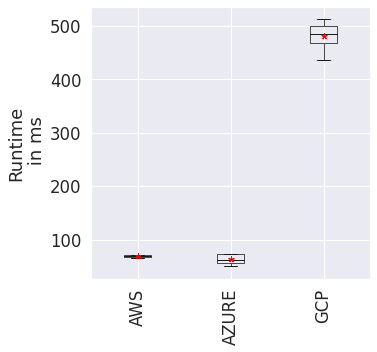

In [15]:
# Runtime Boxplots
mean_region_df = df[['provider', 'region', 'runtime']].groupby(['provider', 'region'], observed=True).mean()
mean_region_df

fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = mean_region_df.groupby('provider')

axes = utils.boxplot(axes, bxdf, "Runtime\n in ms", lambda x: x, rot=45, with_mean=True)

labels = []
for tick in axes.get_xticklabels():
    provider =  tick.get_text().split(',')[0].strip()[1:]
    labels.append(provider)
axes.set_xticklabels(labels, rotation=90)

utils.savefig(fig, ['region_analysis', f'runtime_boxplot'], cvbx=bxdf.describe())

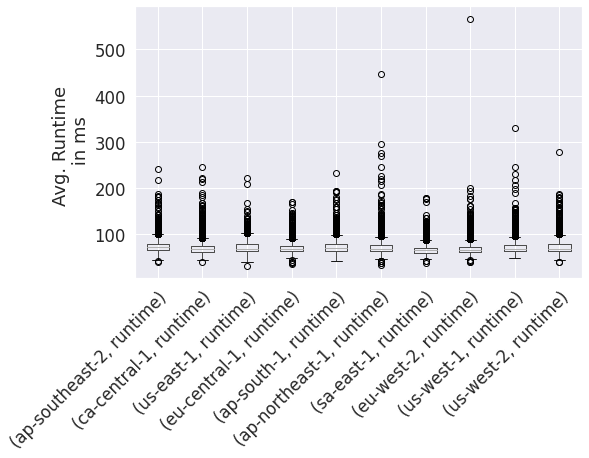

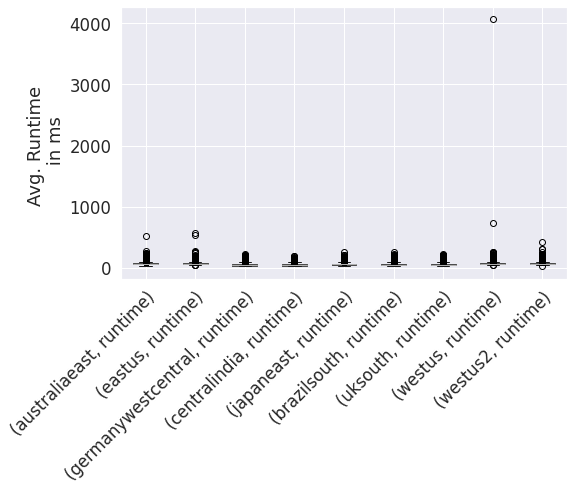

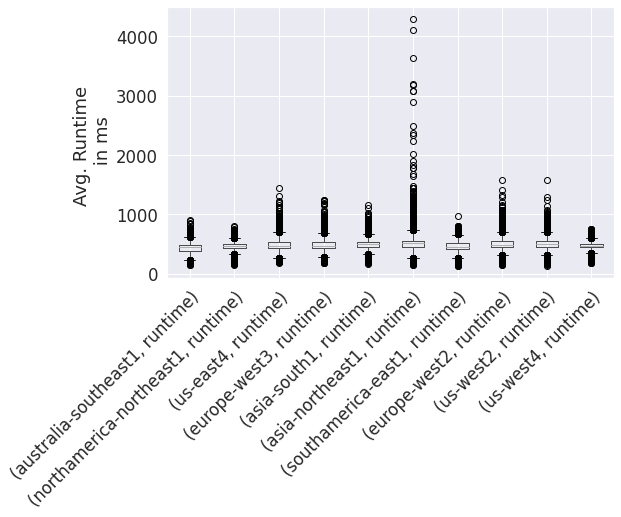

In [16]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(45)
        
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axes.set_ylabel('Avg. Runtime \n in ms')
    plt.show()
    plt.close()

# CPU Types Analysis
Different Types of CPUs for the different regions.

In [17]:
df = df.sort_values(by=['provider', 'measure group', 'region', 'driver_invocation', 'workload_invocation'])

unique_cpu_types_df = df.groupby(['measure group','provider', 'region', 'cpuType'], observed=True)['cpuType'].count() #.agg({'cpuType':'count'})
unique_cpu_types_df = pd.DataFrame(unique_cpu_types_df).groupby(['provider', 'region'], group_keys=False, observed=True).apply(lambda df: (df['cpuType'] / df['cpuType'].sum()) * 100)
unique_cpu_types_percentage_df = pd.DataFrame(unique_cpu_types_df)
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.rename(columns={'cpuType': 'Percentage'})
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.reset_index('cpuType')
unique_cpu_types_pivoted_df = unique_cpu_types_percentage_df.pivot(columns=['cpuType'])
unique_cpu_types_pivoted_df

Percentage  \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    16.847237     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamerica-northeast1                                                NaN     
East US        AWS      us-east-1                                                              NaN     
               AZURE    eastus                                                           24.811459     
               GCP      us-east4                                                               NaN     
Germany        AWS      eu-central-1                                                           NaN     
               AZURE    germanywestcentral                                                     NaN     
               GCP      europe-west3                                                           NaN     
India          AWS      ap-south-1                                                             NaN     
               AZURE    centralindia                                                      0.323737     
               GCP      asia-south1                                                            NaN     
Japan          AWS      ap-northeast-1                                                         NaN     
               AZURE    japaneast                                                         0.057824     
               GCP      asia-northeast1                                                        NaN     
South America  AWS      sa-east-1                                                              NaN     
               AZURE    brazilsouth                                                      26.970616     
               GCP      southamerica-east1                                                     NaN     
United Kingdom AWS      eu-west-2                                                              NaN     
               AZURE    uksouth                                                          10.160088     
               GCP      europe-west2                                                           NaN     
West US        AWS      us-west-1                                                              NaN     
                        us-west-2                                                              NaN     
               AZURE    westus                                                           16.741396     
                        westus2                                                           1.160833     
               GCP      us-west2                                                               NaN     
                        us-west4                                                               NaN     

                                                                                                      \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    57.868364     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamer

In [18]:
unique_cpu_types_pivoted_df

Percentage  \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    16.847237     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamerica-northeast1                                                NaN     
East US        AWS      us-east-1                                                              NaN     
               AZURE    eastus                                                           24.811459     
               GCP      us-east4                                                               NaN     
Germany        AWS      eu-central-1                                                           NaN     
               AZURE    germanywestcentral                                                     NaN     
               GCP      europe-west3                                                           NaN     
India          AWS      ap-south-1                                                             NaN     
               AZURE    centralindia                                                      0.323737     
               GCP      asia-south1                                                            NaN     
Japan          AWS      ap-northeast-1                                                         NaN     
               AZURE    japaneast                                                         0.057824     
               GCP      asia-northeast1                                                        NaN     
South America  AWS      sa-east-1                                                              NaN     
               AZURE    brazilsouth                                                      26.970616     
               GCP      southamerica-east1                                                     NaN     
United Kingdom AWS      eu-west-2                                                              NaN     
               AZURE    uksouth                                                          10.160088     
               GCP      europe-west2                                                           NaN     
West US        AWS      us-west-1                                                              NaN     
                        us-west-2                                                              NaN     
               AZURE    westus                                                           16.741396     
                        westus2                                                           1.160833     
               GCP      us-west2                                                               NaN     
                        us-west4                                                               NaN     

                                                                                                      \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    57.868364     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamer

In [19]:
cpu_map = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon\n@2.50GHz\n (Model 63)",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85": "Xeon\nPlatinum\n8171M\n@2.60GHz\n(Model 85)",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79": "Xeon\nE5-2673 v4\n@2.30GHz\n(Model 79)",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85": "Xeon\nPlatinum\n8272CL\n@2.60GHz\n(Model 85)",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63": "Xeon\nE5-2673 v3\n@2.40GHz\n(Model 63)",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63": "Xeon\n@3.00GHz\n(Model 63)",
    "unknown - Model 63": "Model 63",
    "unknown - Model 85": "Model 85",
    "unknown - Model 79": "Model 79"
}

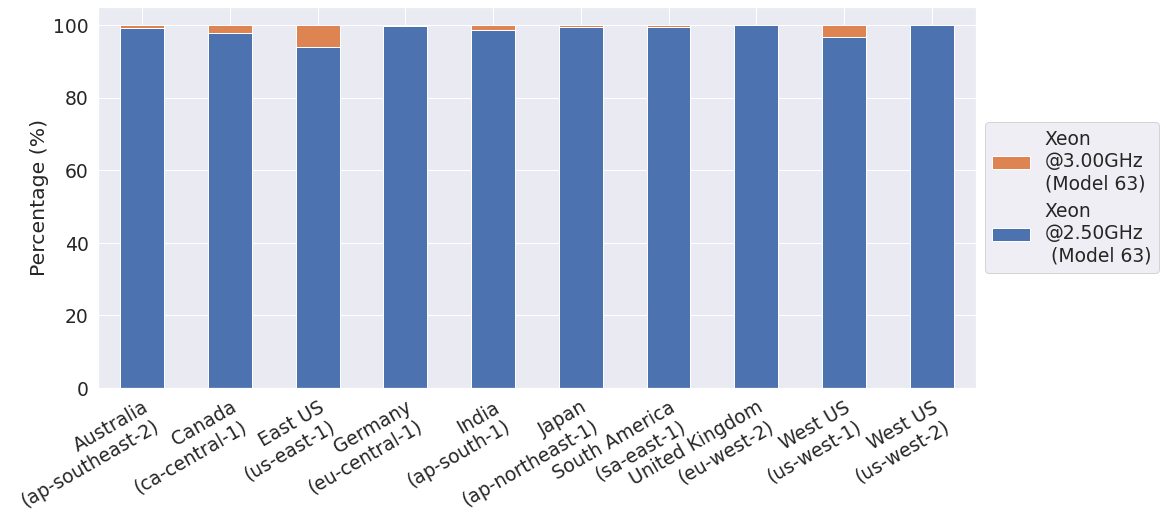

cpu_types_percentrage 
                                         Xeon\n@2.50GHz\n (Model 63)  \
measure group  provider region                                        
Australia      AWS      ap-southeast-2                    99.021583   
Canada         AWS      ca-central-1                      97.670003   
East US        AWS      us-east-1                         94.003120   
Germany        AWS      eu-central-1                      99.712147   
India          AWS      ap-south-1                        98.658143   
Japan          AWS      ap-northeast-1                    99.539436   
South America  AWS      sa-east-1                         99.343469   
United Kingdom AWS      eu-west-2                         99.953912   
West US        AWS      us-west-1                         96.549142   
                        us-west-2                         99.965350   

                                        Xeon\n@3.00GHz\n(Model 63)  
measure group  provider region                        

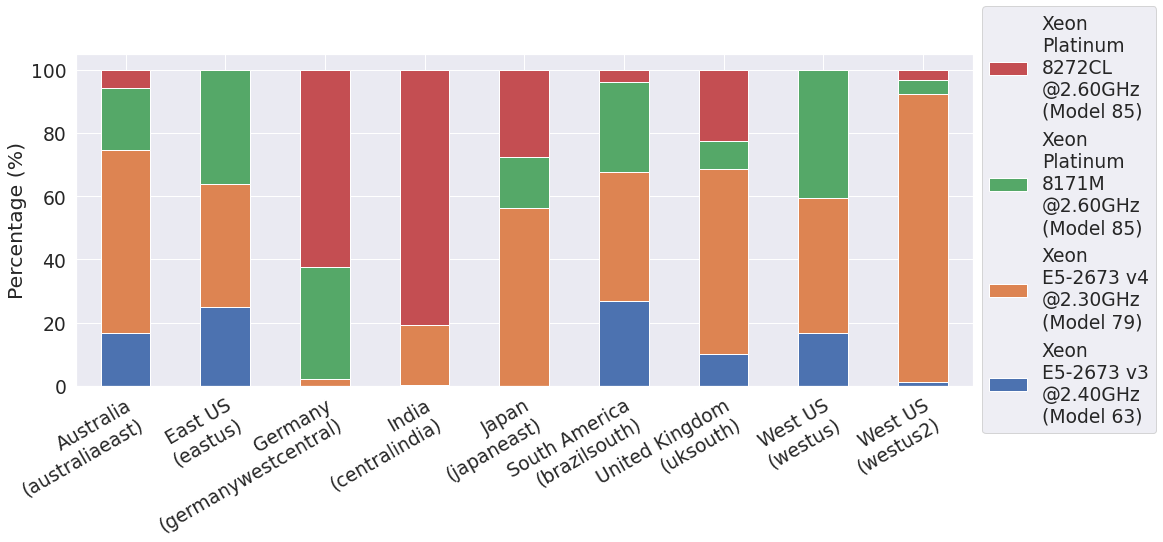

cpu_types_percentrage 
                                             Xeon\nE5-2673 v3\n@2.40GHz\n(Model 63)  \
measure group  provider region                                                       
Australia      AZURE    australiaeast                                    16.847237   
East US        AZURE    eastus                                           24.811459   
Germany        AZURE    germanywestcentral                                     NaN   
India          AZURE    centralindia                                      0.323737   
Japan          AZURE    japaneast                                         0.057824   
South America  AZURE    brazilsouth                                      26.970616   
United Kingdom AZURE    uksouth                                          10.160088   
West US        AZURE    westus                                           16.741396   
                        westus2                                           1.160833   

                             

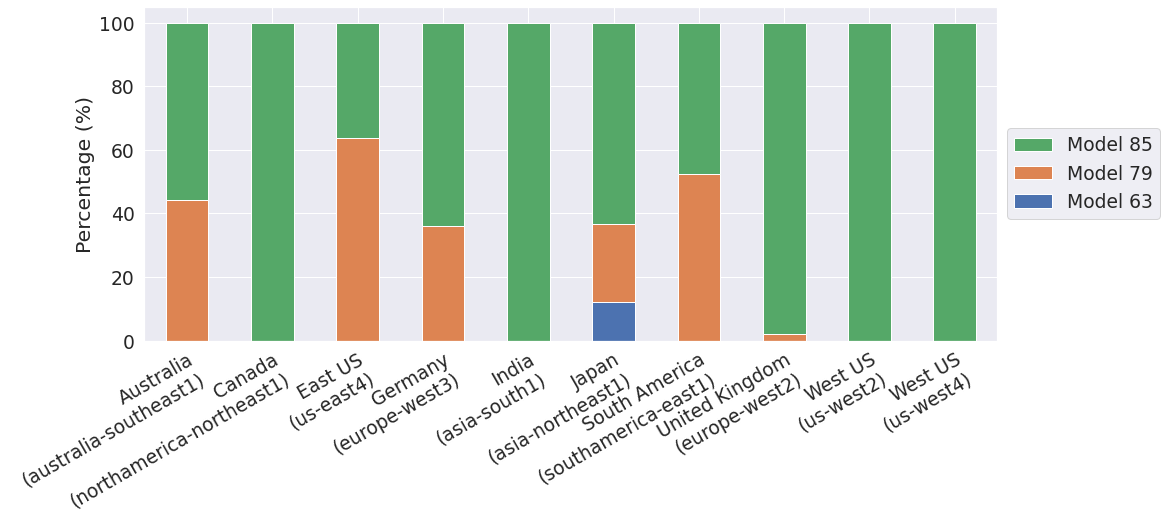

cpu_types_percentrage 
                                                   Model 63   Model 79  \
measure group  provider region                                          
Australia      GCP      australia-southeast1           NaN  44.096524   
Canada         GCP      northamerica-northeast1        NaN        NaN   
East US        GCP      us-east4                       NaN  63.603976   
Germany        GCP      europe-west3                   NaN  36.057002   
India          GCP      asia-south1                    NaN        NaN   
Japan          GCP      asia-northeast1          12.207598  24.622105   
South America  GCP      southamerica-east1             NaN  52.296373   
United Kingdom GCP      europe-west2                   NaN   2.091954   
West US        GCP      us-west2                       NaN        NaN   
                        us-west4                       NaN        NaN   

                                                   Model 85  
measure group  provider region       

In [20]:
sns.set(font_scale=1.7)
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(14,7))
    subdf = unique_cpu_types_pivoted_df
    providerdf = subdf[subdf.index.isin([provider], level=1)]

    cols = providerdf.columns.droplevel(0)
    new_cols = [cpu_map[x] for x in cols]
    providerdf.columns = new_cols
    providerdf = providerdf.dropna(axis=1, how='all')

    providerdf.plot.bar(stacked=True, ax=axes, rot=0)
    
    # Put Legend To Outside
    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Reverse labels fix
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles[::-1], labels[::-1], title='', loc='center left', bbox_to_anchor=(1, 0.5))

    axes.set_xlabel('')
    axes.set_ylabel('Percentage (%)')
    
    # Set Region Names
    labels = []
    i = 0
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        region =  tick.get_text().split(',')[2].strip()[:-1]
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
        i+=1
        
    axes.set_xticklabels(labels)
    axes.set_xticklabels(axes.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    fig.tight_layout(pad=0)
    utils.plot( ['region_analysis', f'cpu_types_{provider}'], cpu_types_percentrage=providerdf)

In [21]:
cputype_per_invocation_df = pd.DataFrame(df.groupby(['provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().rename('Count'))

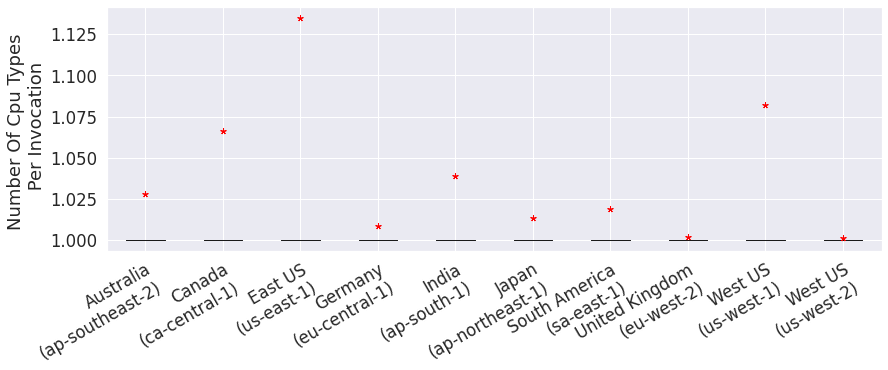

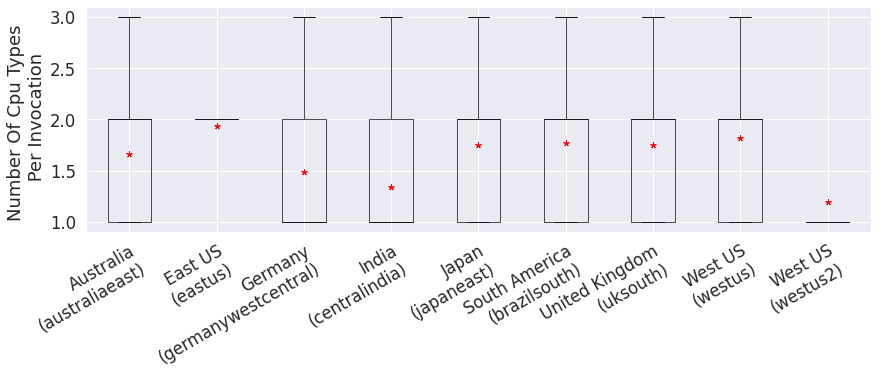

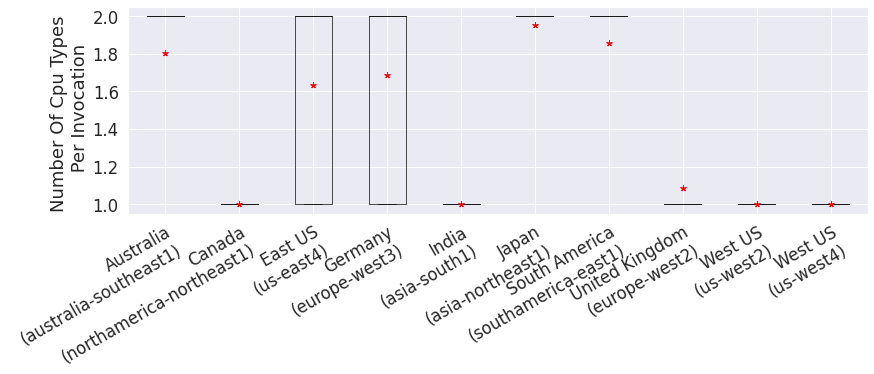

In [22]:
sns.set(font_scale=1.5)
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(12,5))
    subdf = cputype_per_invocation_df
    provdf = subdf.loc[provider]
    provdfgrp = provdf.groupby('region')
    #provdf.boxplot(by='region', rot=45, ax=axes)
    
    axes = utils.boxplot(axes, provdfgrp, "Runtime\n in ms", lambda x: x, rot=0, with_mean=True)
    
    # Set Region Names
    labels = []
    i = 0
    for tick in axes.get_xticklabels():
        region =  tick.get_text().split(',')[0].strip().strip('(')
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
        i+=1
    axes.set_xticklabels(labels)
    
    # Other Formatting
    axes.set_title('')
    fig.suptitle('')
    axes.set_xlabel('')
    axes.set_ylabel('Number Of Cpu Types \n Per Invocation')
    
    axes.set_xticklabels(axes.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    
    fig.tight_layout(pad=0)
    utils.savefig(fig, ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())
    # utils.plot( ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())